# Introduction to [PyStan](http://mc-stan.org/)

This is a gentle introduction to PyStan, the Python wrapper for the Stan analysis platform developed by Andrew Gelman and company (largely out of Columbia University).  This intro is motivated by the need for an estimator that does not currently exist in the [Statsmodels](http://statsmodels.sourceforge.net/) project.  Specifically, I need a [multivariate probit](https://en.wikipedia.org/wiki/Multivariate_probit_model) estimator, but I can envision additional scenarios in which a more flexible suite of options is available.  The upside of Stan in general is a remarkable level of flexibility in designing estimating procedures and structures.  The downside is a much higher bar for use, with respect to the technical knowledge one must apply.  One cannot simply feed a R-style formula string into an estimator and get back nicely formatted output with a host of pre-calculated diagnostics.  It appears that all of these things must be defined with some detail.  As with many things, the low-level flexibility is simultaneously an advantage and disadvantage of the library.  That being said, getting good with Stan likely forces one to know their shit.

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import pystan as ps
import scipy.stats as stats

%pylab inline
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


Populating the interactive namespace from numpy and matplotlib


*Note that I had to update anaconda again after the install of PyStan.  Apparently, it changed the version of numpy.*

## The Classic Coin Toss Scenario

Stan fits models in a generic way.  Whether it's sampling from a distribution or running more complicated estimation routines, the basic units of any model are blocks.  To get a feel for how this workflow goes, we make our way through an excellent [intro to computational statistics in Python](http://people.duke.edu/~ccc14/sta-663/PyStan.html).  This site actually covers a lot of useful stuff, far beyond the section on PyStan.  

In any event, the first example is a classic.  We have a coin, but is it biased?

The first item on the agenda is to build our Stan code (remember, Python is just a wrapper that serves up our calls to the Stan platform).  It consists of a number of blocks, which are described in the [Stan article](http://www.stat.columbia.edu/~gelman/research/unpublished/stan-resubmit-JSS1293.pdf) published by the [Journal of Statistical Software](http://www.jstatsoft.org/index):

1. **`Data`** declares the raw variables (both scalars and arrays) to be used in the analysis, complete with data type and permissible range;
2. **`Transformed Data`** declares and defines derived variables based upon the raw variables in the `Data` block;
3. **`Parameters`** declares the parameters to be estimated *and* any relevant prior parameters;
4. **`Transformed Parameters`** declares and defines derived parameters based upon the raw parameters in the `Parameter` block;
5. **`Model`** defines the log probability function (the relevant likelihood for the estimator in question), and relevant prior distributions; and,
6. **`Generated Quantities`** declares and defines additional output one may want (like summary stats or perhaps diagnostics).

In [2]:
coin_code="""
data{
    int<lower=0> n; //number of tosses
    int<lower=0> y; //number of heads
}
parameters{
    real<lower=0,upper=1> p;
}
model{
    p ~ beta(2,2);
    y ~ binomial(n,p);
}
"""

In [3]:
coin_code = """
data {
    int<lower=0> n; // number of tosses
    int<lower=0> y; // number of heads
}
transformed data {}
parameters {
    real<lower=0, upper=1> p;
}
transformed parameters {}
model {
    p ~ beta(2, 2);
    y ~ binomial(n, p);
}
generated quantities {}
"""

Let's unpack this a bit.  First note that not all blocks are required in all cases. Second, we have given explicit boundaries for our raw data and our parameters.  Our data on the number of tosses - total (`n`) and heads only (`y`) - is limited to non-negative integers.  The probability of heads (`p`) is bounded on the unit interval.

In the model block, we have provided a prior distribution for `p`, and the distribution that governs the likelihood used in estimation (`y`).  What does our prior actually look like?

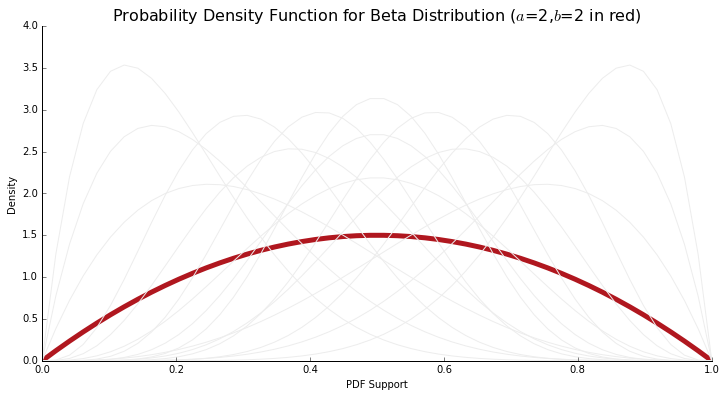

In [4]:
#Generate plot object
fig,ax=plt.subplots(figsize=(12,6))

#Plot data at many values of values of the `a` & `b` parameters for the beta distribution
for a in range(2,9,2):
    for b in range(2,9,2):
        if (a==2) & (b==2):
            Series(stats.beta.pdf(np.linspace(.0001,1),a,b),index=np.linspace(.0001,1)).\
                plot(kind='line',ax=ax,color='#B0171F',lw=5)
        else:
            Series(stats.beta.pdf(np.linspace(.0001,1),a,b),index=np.linspace(.0001,1)).\
                plot(kind='line',ax=ax,color='#EDEDED')

#Fix labels
ax.set_xlabel('PDF Support')
ax.set_ylabel('Density')
ax.set_title('Probability Density Function for Beta Distribution ($a$=2,$b$=2 in red)',fontsize=16)

#Fix axis
simpleaxis(ax)

So our prior is a ($B(2,2)$) is symmetrically concave.  The implication is clearly an expected value of .5, which would be consistent with a fair coin.  Note that if the prior is not specified, an uninformative, uniform prior is the default ($B(1,1)$).

Now that we have all of our declarations, we need some underlying data to serve as the bases for adjusting our prior distribution.

In [5]:
coin_data={'n':100,
           'y':61}

We are in a position to actually fit the model at this point.

In [6]:
help(ps.stan)

Help on function stan in module pystan.api:

stan(file=None, model_name='anon_model', model_code=None, fit=None, data=None, pars=None, chains=4, iter=2000, warmup=None, thin=1, init='random', seed=None, algorithm=None, control=None, sample_file=None, diagnostic_file=None, save_dso=True, verbose=False, boost_lib=None, eigen_lib=None, n_jobs=-1, **kwargs)
    Fit a model using Stan.
    
    Parameters
    ----------
    
    file : string {'filename', file-like object}
        Model code must found via one of the following parameters: `file` or
        `model_code`.
    
        If `file` is a filename, the string passed as an argument is expected
        to be a filename containing the Stan model specification.
    
        If `file` is a file object, the object passed must have a 'read' method
        (file-like object) that is called to fetch the Stan model specification.
    
    charset : string, optional
        If bytes or files are provided, this charset is used to decode. 'utf-

In [7]:
fit=ps.stan(model_code=coin_code,data=coin_data,iter=1000,chains=1)

CompileError: command 'C:\\cygwin64\\bin\\gcc.exe' failed with exit status 1

In [ ]:
coin_code = """
data {
    int<lower=0> n; // number of tosses
    int<lower=0> y; // number of heads
}
transformed data {}
parameters {
    real<lower=0, upper=1> p;
}
transformed parameters {}
model {
    p ~ beta(2, 2);
    y ~ binomial(n, p);
}
generated quantities {}
"""

coin_dat = {
             'n': 100,
             'y': 61,
            }

fit = ps.stan(model_code=coin_code, data=coin_dat, iter=1000, chains=1)

In [9]:
!gcc --version

gcc (GCC) 5.2.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

